In [2]:
#
# Project 2, starter code Part a
#

import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.python.client import device_lib
from tensorflow.keras import models
from skimage import color

In [3]:
# This is required when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(gpus)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        devices = device_lib.list_local_devices()
        avail_gpu = [x for x in devices if x.device_type == 'GPU']
        print('\n',avail_gpu)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No gpus available")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs

 [name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3048682292
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18111755216240592777
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [4]:
# Fixed, no need change
def load_data(file):
    file = 'data\\'+file
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  # python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32) / 255
    data = tf.reshape(data, [-1,3, 32, 32])
    data = tf.transpose(data,(0,2,3,1))
    labels = np.array(labels, dtype=np.int32)
    return data, labels

In [5]:
def load_history(path):
    path = 'histories\\'+path
    with open(path, 'rb') as fo:
        try:
            history = pickle.load(fo)
        except UnicodeDecodeError:  # python 3.x
            fo.seek(0)
            history = pickle.load(fo, encoding='latin1')

    #data, labels = history['data'], history['labels']

    #history = np.array(history, dtype=np.float32) / 255
    return history

In [6]:
class History_trained_model(object):
    def __init__(self, history, epoch, params):
        self.history = history
        self.epoch = epoch
        self.params = params

In [7]:
def make_model(num_ch_c1, num_ch_c2, use_dropout):
    ''' Note: This model is incomplete. You need to add suitable layers.
    '''

    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(32,32,3)))
    model.add(layers.Conv2D(num_ch_c1, 9, padding='valid', activation='relu', input_shape=(None, None, 3)))
    model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'))
    model.add(layers.Conv2D(num_ch_c2, 5, padding='valid', activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'))
    model.add(layers.Flatten())
    model.add(layers.Dense(300, activation=None))
    model.add(layers.Dense(10, use_bias=True, activation='softmax', input_shape=(300,)))  # Here no softmax because we have combined it with the loss
    return model
#model = make_model(50,60,False)
#model.summary()

In [8]:
def save_model(num_ch_c1,num_ch_c2,optimizer_,history,use_dropout):
    # Create folder to store models and results
    if not os.path.exists('./models'):
        os.mkdir('./models')
    if not os.path.exists('./results'):
        os.mkdir('./results')
    if not os.path.exists('./histories'):
        os.mkdir('./histories')
    
    # Save model
    if use_dropout:
        model.save(f'./models/QuestionA2_{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout')
        with open(f'histories/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)
    else:
        model.save(f'./models/QuestionA2_{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout')
        with open(f'histories/{num_ch_c1}_{num_ch_c2}_{optimizer_}_nodropout', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)

In [9]:
def create_opt(optimizer_,lr):
    if optimizer_ == 'SGD':
        optimizer = keras.optimizers.SGD(learning_rate=lr)
    elif optimizer_ == 'SGD-momentum':  # Question 3(a)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum = 0.1)
    elif optimizer_ == 'RMSProp':  # Question 3(b)
        optimizer = keras.optimizers.RMSprop(learning_rate=lr)
    elif optimizer_ == 'Adam':  # Question 3(c)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
    else:
        raise NotImplementedError(f'You do not need to handle [{optimizer_}] in this project.')
    return optimizer

In [10]:
# Save the plot for losses
def plot_loss(loss,test_loss,use_dropout):
    train_loss = loss
    val_loss = test_loss
    plt.figure(figsize=(10,6))
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Test')
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    if use_dropout:
        plt.savefig(
            f'./results/QuestionA2_{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout_loss.pdf')
    else:
        plt.savefig(
            f'./results/QuestionA2_{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout_loss.pdf'
        )
    plt.show()
    plt.close()

In [11]:
# Save the plot for accuracy
def plot_acc(acc,val_acc,use_dropout):
    train_acc = acc
    test_acc = val_acc
    plt.figure(figsize=(10,8))
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test')
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    if use_dropout:
        plt.savefig(
            f'./results/QuestionA2_{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout_accuracy.pdf'
        )
    else:
        plt.savefig(
            f'./results/QuestionA2_{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout_accuracy.pdf'
        )
    plt.show()
    plt.close()

Epoch 1/500
79/79 [==============================] - 2s 14ms/step - loss: 2.3166 - accuracy: 0.0970 - val_loss: 2.2950 - val_accuracy: 0.1275
Epoch 2/500
79/79 [==============================] - 1s 11ms/step - loss: 2.2908 - accuracy: 0.1519 - val_loss: 2.2839 - val_accuracy: 0.1555
Epoch 3/500
79/79 [==============================] - 1s 11ms/step - loss: 2.2810 - accuracy: 0.1610 - val_loss: 2.2759 - val_accuracy: 0.1470
Epoch 4/500
79/79 [==============================] - 1s 11ms/step - loss: 2.2727 - accuracy: 0.1589 - val_loss: 2.2680 - val_accuracy: 0.1695
Epoch 5/500
79/79 [==============================] - 1s 11ms/step - loss: 2.2648 - accuracy: 0.1769 - val_loss: 2.2592 - val_accuracy: 0.1810
Epoch 6/500
79/79 [==============================] - 1s 11ms/step - loss: 2.2558 - accuracy: 0.1780 - val_loss: 2.2495 - val_accuracy: 0.1925
Epoch 7/500
79/79 [==============================] - 1s 11ms/step - loss: 2.2459 - accuracy: 0.1950 - val_loss: 2.2386 - val_accuracy: 0.2055
Epoch 

79/79 [==============================] - 1s 11ms/step - loss: 1.5901 - accuracy: 0.4345 - val_loss: 1.6457 - val_accuracy: 0.4090
Epoch 116/500
79/79 [==============================] - 1s 11ms/step - loss: 1.5847 - accuracy: 0.4415 - val_loss: 1.6384 - val_accuracy: 0.4255
Epoch 117/500
79/79 [==============================] - 1s 11ms/step - loss: 1.5905 - accuracy: 0.4352 - val_loss: 1.6340 - val_accuracy: 0.4240
Epoch 118/500
79/79 [==============================] - 1s 11ms/step - loss: 1.5899 - accuracy: 0.4318 - val_loss: 1.6301 - val_accuracy: 0.4090
Epoch 119/500
79/79 [==============================] - 1s 11ms/step - loss: 1.5942 - accuracy: 0.4281 - val_loss: 1.6383 - val_accuracy: 0.4120
Epoch 120/500
79/79 [==============================] - 1s 11ms/step - loss: 1.5784 - accuracy: 0.4391 - val_loss: 1.6762 - val_accuracy: 0.4005
Epoch 121/500
79/79 [==============================] - 1s 11ms/step - loss: 1.5839 - accuracy: 0.4368 - val_loss: 1.6349 - val_accuracy: 0.4045
Epoch 

Epoch 172/500
79/79 [==============================] - 1s 11ms/step - loss: 1.4709 - accuracy: 0.4726 - val_loss: 1.5407 - val_accuracy: 0.4490
Epoch 173/500
79/79 [==============================] - 1s 11ms/step - loss: 1.4776 - accuracy: 0.4797 - val_loss: 1.5587 - val_accuracy: 0.4290
Epoch 174/500
79/79 [==============================] - 1s 11ms/step - loss: 1.4571 - accuracy: 0.4782 - val_loss: 1.5493 - val_accuracy: 0.4555
Epoch 175/500
79/79 [==============================] - 1s 11ms/step - loss: 1.4624 - accuracy: 0.4817 - val_loss: 1.5617 - val_accuracy: 0.4485
Epoch 176/500
79/79 [==============================] - 1s 11ms/step - loss: 1.4638 - accuracy: 0.4784 - val_loss: 1.5222 - val_accuracy: 0.4515
Epoch 177/500
79/79 [==============================] - 1s 11ms/step - loss: 1.4518 - accuracy: 0.4799 - val_loss: 1.5838 - val_accuracy: 0.4410
Epoch 178/500
79/79 [==============================] - 1s 11ms/step - loss: 1.4278 - accuracy: 0.4835 - val_loss: 1.5705 - val_accuracy:

Epoch 229/500
79/79 [==============================] - 1s 11ms/step - loss: 1.3987 - accuracy: 0.5092 - val_loss: 1.7344 - val_accuracy: 0.4145
Epoch 230/500
79/79 [==============================] - 1s 11ms/step - loss: 1.3750 - accuracy: 0.5158 - val_loss: 1.5060 - val_accuracy: 0.4700
Epoch 231/500
79/79 [==============================] - 1s 11ms/step - loss: 1.3725 - accuracy: 0.5223 - val_loss: 1.5113 - val_accuracy: 0.4565
Epoch 232/500
79/79 [==============================] - 1s 11ms/step - loss: 1.3509 - accuracy: 0.5242 - val_loss: 1.5194 - val_accuracy: 0.4500
Epoch 233/500
79/79 [==============================] - 1s 11ms/step - loss: 1.3728 - accuracy: 0.5157 - val_loss: 1.5417 - val_accuracy: 0.4520
Epoch 234/500
79/79 [==============================] - 1s 11ms/step - loss: 1.3681 - accuracy: 0.5160 - val_loss: 1.5751 - val_accuracy: 0.4460
Epoch 235/500
79/79 [==============================] - 1s 11ms/step - loss: 1.3765 - accuracy: 0.5142 - val_loss: 1.6008 - val_accuracy:

Epoch 286/500
79/79 [==============================] - 1s 11ms/step - loss: 1.3347 - accuracy: 0.5336 - val_loss: 1.4111 - val_accuracy: 0.5030
Epoch 287/500
79/79 [==============================] - 1s 11ms/step - loss: 1.2947 - accuracy: 0.5460 - val_loss: 1.5171 - val_accuracy: 0.4515
Epoch 288/500
79/79 [==============================] - 1s 11ms/step - loss: 1.3001 - accuracy: 0.5458 - val_loss: 1.4501 - val_accuracy: 0.4790
Epoch 289/500
79/79 [==============================] - 1s 11ms/step - loss: 1.2980 - accuracy: 0.5465 - val_loss: 1.4210 - val_accuracy: 0.4980
Epoch 290/500
79/79 [==============================] - 1s 11ms/step - loss: 1.2944 - accuracy: 0.5443 - val_loss: 1.4097 - val_accuracy: 0.5045
Epoch 291/500
79/79 [==============================] - 1s 11ms/step - loss: 1.3039 - accuracy: 0.5421 - val_loss: 1.5820 - val_accuracy: 0.4425
Epoch 292/500
79/79 [==============================] - 1s 11ms/step - loss: 1.2986 - accuracy: 0.5471 - val_loss: 1.3993 - val_accuracy:

Epoch 343/500
79/79 [==============================] - 1s 11ms/step - loss: 1.2351 - accuracy: 0.5685 - val_loss: 1.5131 - val_accuracy: 0.4725
Epoch 344/500
79/79 [==============================] - 1s 11ms/step - loss: 1.2213 - accuracy: 0.5708 - val_loss: 1.8672 - val_accuracy: 0.3835
Epoch 345/500
79/79 [==============================] - 1s 11ms/step - loss: 1.2434 - accuracy: 0.5675 - val_loss: 1.3844 - val_accuracy: 0.5050
Epoch 346/500
79/79 [==============================] - 1s 11ms/step - loss: 1.2251 - accuracy: 0.5680 - val_loss: 1.4003 - val_accuracy: 0.5105
Epoch 347/500
79/79 [==============================] - 1s 11ms/step - loss: 1.2105 - accuracy: 0.5702 - val_loss: 1.3906 - val_accuracy: 0.4945
Epoch 348/500
79/79 [==============================] - 1s 11ms/step - loss: 1.2021 - accuracy: 0.5797 - val_loss: 1.5533 - val_accuracy: 0.4510
Epoch 349/500
79/79 [==============================] - 1s 11ms/step - loss: 1.2437 - accuracy: 0.5639 - val_loss: 1.5561 - val_accuracy:

Epoch 400/500
79/79 [==============================] - 1s 11ms/step - loss: 1.1604 - accuracy: 0.5953 - val_loss: 1.3660 - val_accuracy: 0.5195
Epoch 401/500
79/79 [==============================] - 1s 11ms/step - loss: 1.1564 - accuracy: 0.5984 - val_loss: 1.7327 - val_accuracy: 0.3715
Epoch 402/500
79/79 [==============================] - 1s 11ms/step - loss: 1.1820 - accuracy: 0.5828 - val_loss: 1.3614 - val_accuracy: 0.5215
Epoch 403/500
79/79 [==============================] - 1s 11ms/step - loss: 1.1726 - accuracy: 0.5972 - val_loss: 1.4077 - val_accuracy: 0.4990
Epoch 404/500
79/79 [==============================] - 1s 11ms/step - loss: 1.1726 - accuracy: 0.5953 - val_loss: 1.4970 - val_accuracy: 0.4865
Epoch 405/500
79/79 [==============================] - 1s 11ms/step - loss: 1.1707 - accuracy: 0.5938 - val_loss: 1.3513 - val_accuracy: 0.5235
Epoch 406/500
79/79 [==============================] - 1s 10ms/step - loss: 1.1551 - accuracy: 0.5973 - val_loss: 1.3361 - val_accuracy:

Epoch 457/500
79/79 [==============================] - 1s 11ms/step - loss: 1.1052 - accuracy: 0.6229 - val_loss: 1.3445 - val_accuracy: 0.5315
Epoch 458/500
79/79 [==============================] - 1s 11ms/step - loss: 1.0954 - accuracy: 0.6225 - val_loss: 1.5898 - val_accuracy: 0.4585
Epoch 459/500
79/79 [==============================] - 1s 11ms/step - loss: 1.1283 - accuracy: 0.6124 - val_loss: 1.3382 - val_accuracy: 0.5255
Epoch 460/500
79/79 [==============================] - 1s 11ms/step - loss: 1.0874 - accuracy: 0.6289 - val_loss: 1.4836 - val_accuracy: 0.4780
Epoch 461/500
79/79 [==============================] - 1s 11ms/step - loss: 1.1161 - accuracy: 0.6224 - val_loss: 1.3870 - val_accuracy: 0.5110
Epoch 462/500
79/79 [==============================] - 1s 11ms/step - loss: 1.0918 - accuracy: 0.6215 - val_loss: 1.4112 - val_accuracy: 0.5095
Epoch 463/500
79/79 [==============================] - 1s 11ms/step - loss: 1.0908 - accuracy: 0.6257 - val_loss: 1.3278 - val_accuracy:

C:\Users\Yuhan\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2342: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
C:\Users\Yuhan\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:1395: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: ./models/QuestionA2_50_100_SGD_no_dropout\assets


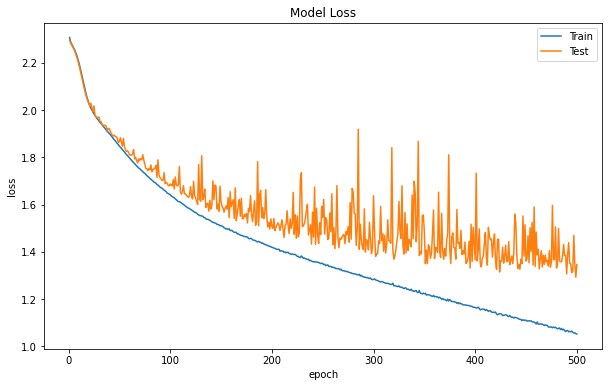

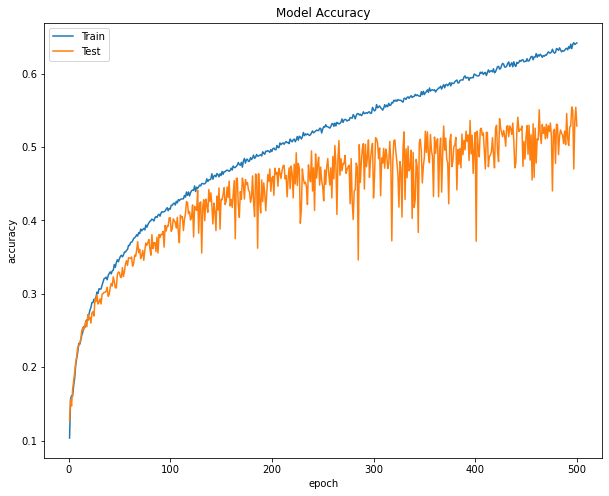

In [31]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

q2_num_ch_c1 = [10, 30, 50, 70, 90]  # Question 2
q2_num_ch_c2 = [20, 40, 60, 80, 100]  # Question 2

num_ch_c1 = 50
num_ch_c2 = 100

epochs = 500  # Fixed
batch_size = 128  # Fixed
learning_rate = 0.001
optimizer_ = 'SGD'  # Question 3
use_dropout = False  # Question 3(d) (see make_model)

x_train, y_train = load_data('data_batch_1')
x_test, y_test = load_data('test_batch_trim')

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = create_opt(optimizer_,learning_rate)

#or num_ch_c1 in q2_num_ch_c1:
    #or num_ch_c2 in q2_num_ch_c2:
        # Initialize model
model = make_model(num_ch_c1, num_ch_c2, use_dropout)

# Training
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test))

save_model(num_ch_c1,num_ch_c2,optimizer_,history,use_dropout)

# Save the plot for losses
plot_loss(history.history['loss'],history.history['val_loss'],use_dropout)

# Save the plot for accuracies
plot_acc(history.history['accuracy'],history.history['val_accuracy'],use_dropout)

In [23]:
histories = []
histories.append(load_history('10_20_SGD_nodropout'))
histories.append(load_history(f'{num_ch_c1}_{num_ch_c2}_SGD_nodropout'))

In [ ]:
plot_acc(histories[1]['accuracy'],histories[1]['val_accuracy'],use_dropout)

In [ ]:
# Display and save test images
if not os.path.exists('./figures'):
        os.mkdir('./figures')
image = x_test[0]
image2 = x_test[1]
for i in range(2):
    plt.title('test image '+str(i))
    plt.imshow(x_test[i])
    plt.savefig(
                f'./figures/test_image_{i+1}.png'
            )

In [30]:
q2_num_ch_c1 = [10, 30, 50, 70, 90]  # Question 2
q2_num_ch_c2 = [20, 40, 60, 80, 100]  # Question 2
optimizers = ['SGD','SGD-momentum','RMSProp','Adam']
histories = {}

for num_ch_c1 in q2_num_ch_c1:
    for num_ch_c2 in q2_num_ch_c2:
        histories[f'{num_ch_c1}_{num_ch_c2}'] = load_history(f'{num_ch_c1}_{num_ch_c2}_SGD_nodropout')
for i in optimizers:
    histories[f'{i}'] = load_history(f'70_60_{i}_nodropout')
histories['Adam_drop'] = load_history('70_60_Adam_dropout')

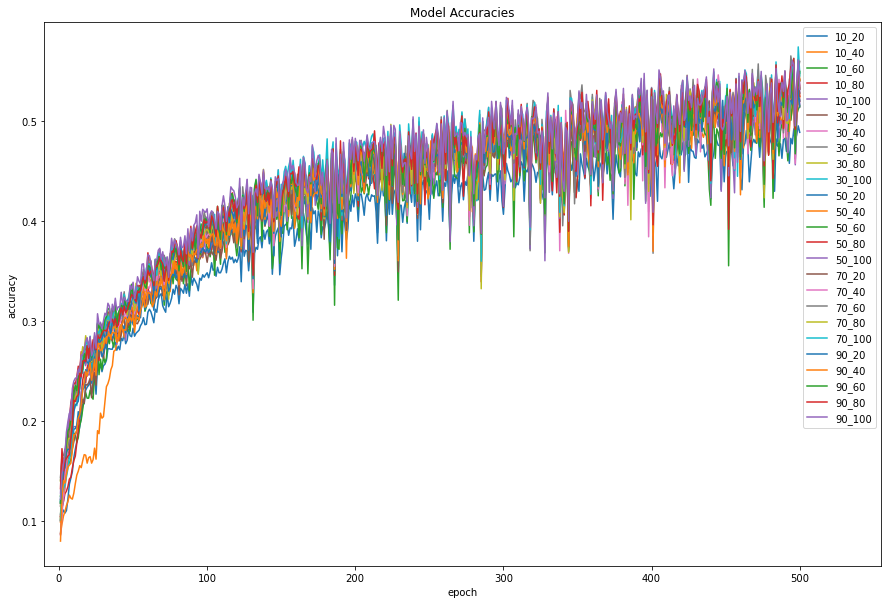

In [53]:
plt.figure(figsize=(15,10))
for num_ch_c1 in q2_num_ch_c1:
    for num_ch_c2 in q2_num_ch_c2:
        plt.plot(range(1, len(histories[f'{num_ch_c1}_{num_ch_c2}']['val_accuracy']) + 1), 
                 histories[f'{num_ch_c1}_{num_ch_c2}']['val_accuracy'], label=f'{num_ch_c1}_{num_ch_c2}')

for i in optimizers:
    plt.plot(range(1, len(histories[f'{i}']['val_accuracy']) + 1), 
                 histories[f'{i}']['val_accuracy'], label=f'optimal_{i}')
plt.plot(range(1, len(histories['Adam_drop']['val_accuracy']) + 1), 
                 histories['Adam_drop']['val_accuracy'], label=f'optimal_Adam_drop')

plt.title('Model Accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xlim([-10,555])
plt.legend()

plt.savefig(
            f'./results/QuestionA4_comparisons_all_accuracy.pdf'
        )

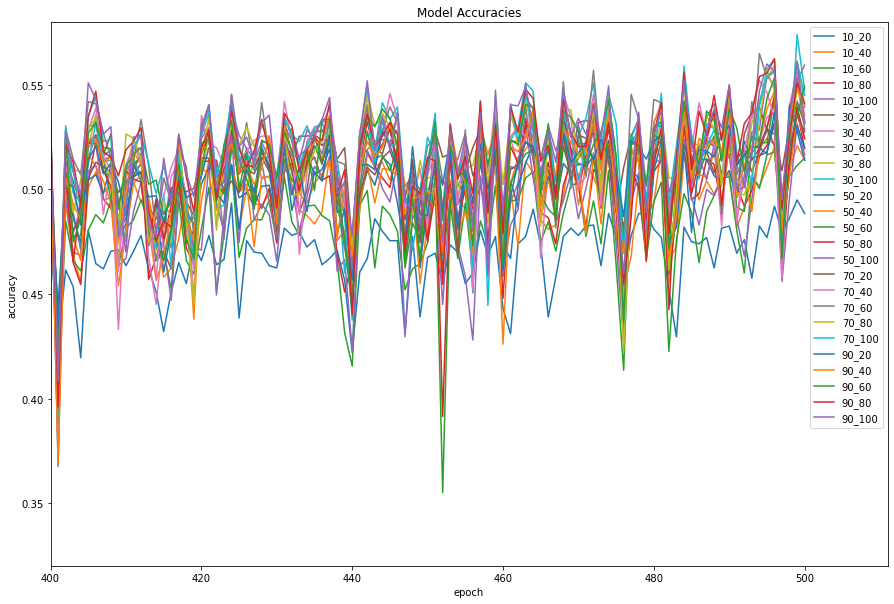

In [57]:
plt.figure(figsize=(15,10))
for num_ch_c1 in q2_num_ch_c1:
    for num_ch_c2 in q2_num_ch_c2:
        plt.plot(range(1, len(histories[f'{num_ch_c1}_{num_ch_c2}']['val_accuracy']) + 1), 
                 histories[f'{num_ch_c1}_{num_ch_c2}']['val_accuracy'], label=f'{num_ch_c1}_{num_ch_c2}')


for i in optimizers:
    plt.plot(range(1, len(histories[f'{i}']['val_accuracy']) + 1), 
                 histories[f'{i}']['val_accuracy'], label=f'optimal_{i}')
plt.plot(range(1, len(histories['Adam_drop']['val_accuracy']) + 1), 
                 histories['Adam_drop']['val_accuracy'], label=f'optimal_Adam_drop')


plt.title('Model Accuracies')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xlim([400,511])
plt.ylim([0.32,0.58])
plt.legend()

plt.savefig(
            f'./results/QuestionA4_comparisons_all_accuracy_zoomed.pdf'
        )

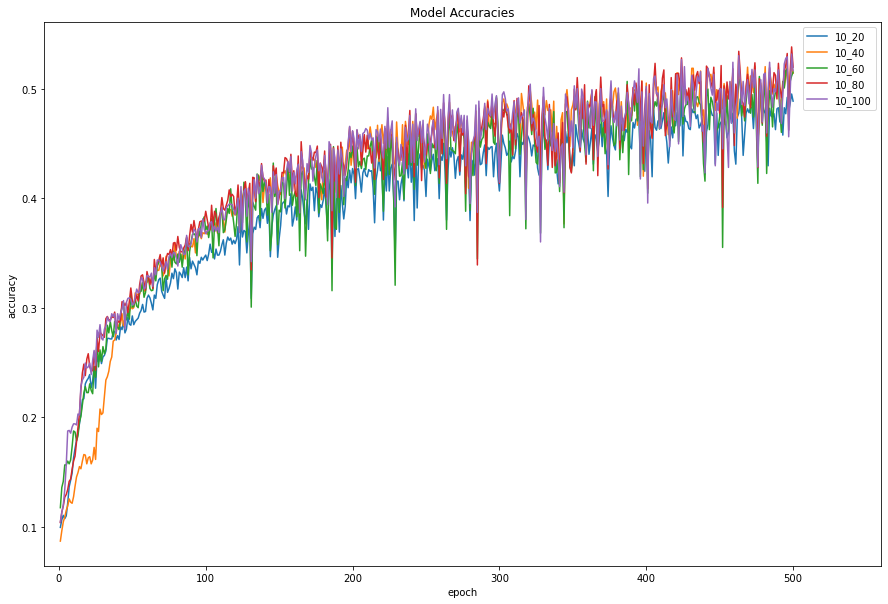

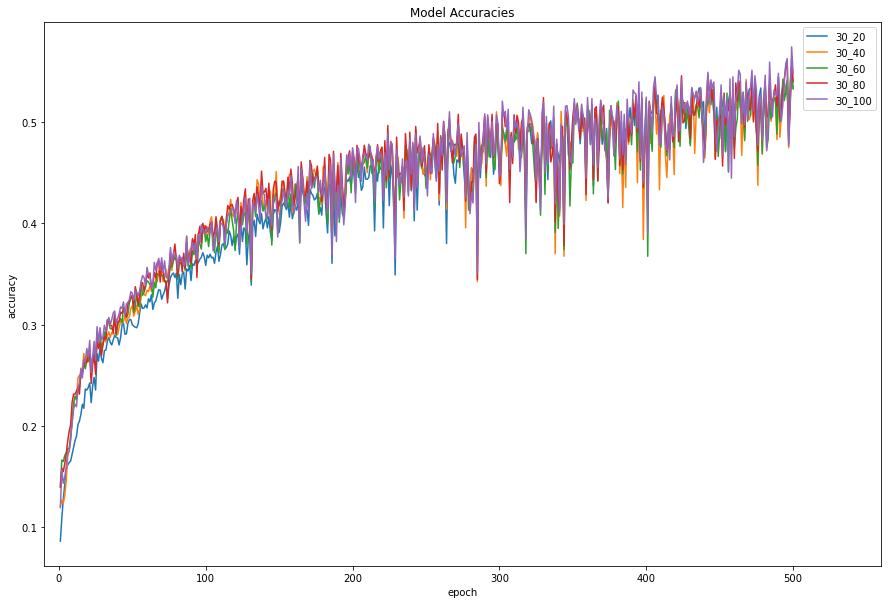

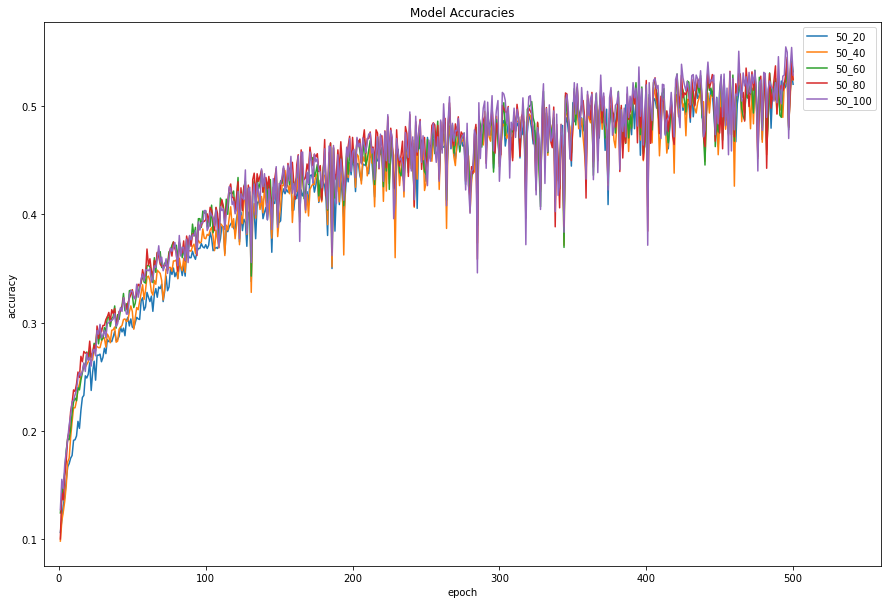

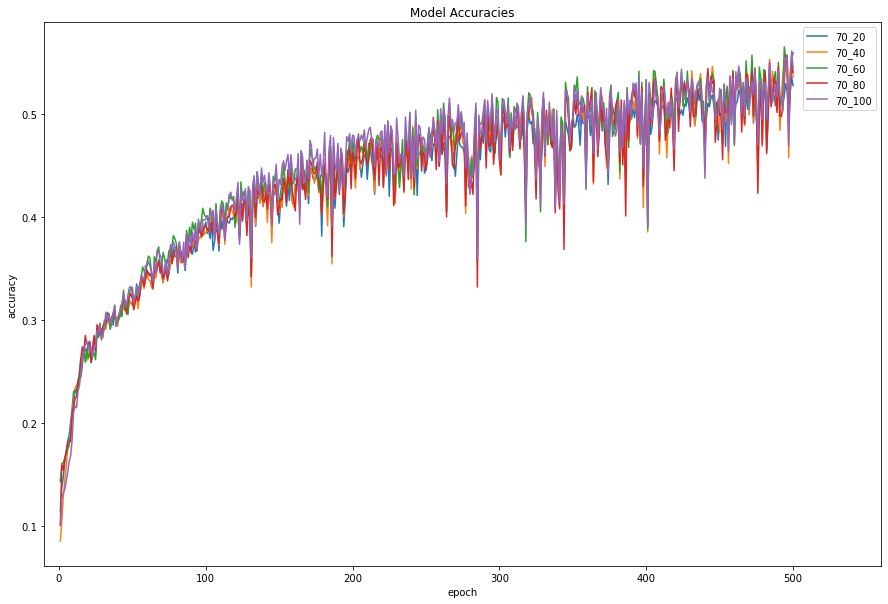

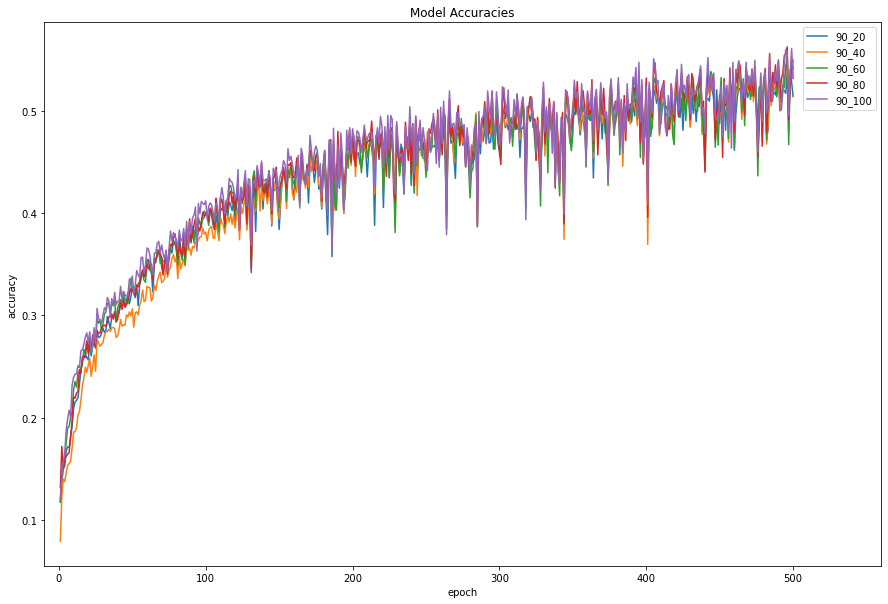

In [33]:
for num_ch_c1 in q2_num_ch_c1:
    plt.figure(figsize=(15,10))
    for num_ch_c2 in q2_num_ch_c2:
        plt.plot(range(1, len(histories[f'{num_ch_c1}_{num_ch_c2}']['val_accuracy']) + 1), 
                 histories[f'{num_ch_c1}_{num_ch_c2}']['val_accuracy'], label=f'{num_ch_c1}_{num_ch_c2}')
    plt.title('Model Accuracies')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.xlim([-10,560])
    plt.legend()
    plt.savefig(
            f'./results/QuestionA2_comparisons_{num_ch_c1}_accuracy.pdf'
        )

In [48]:
accuracies = {}
for num_ch_c1 in q2_num_ch_c1:
    for num_ch_c2 in q2_num_ch_c2:
        avg_acc = sum(histories[f'{num_ch_c1}_{num_ch_c2}']['val_accuracy'][-100:])/100
        accuracies[f'{num_ch_c1}_{num_ch_c2}'] = avg_acc
for i in optimizers:
    avg_acc = sum(histories[f'{i}']['val_accuracy'][-100:])/100
    accuracies[f'{i}'] = avg_acc

avg_acc = sum(histories['Adam_drop']['val_accuracy'][-50:])/50
accuracies['Adam_drop'] = avg_acc
avg_acc = sum(histories['Adam']['val_accuracy'][-50:])/50
accuracies['Adam'] = avg_acc

In [49]:
for keys in accuracies:
    print(f'{keys}\t\t{accuracies[keys]}')

10_20		0.4680449989438057
10_40		0.4939299985766411
10_60		0.480765001475811
10_80		0.4956400007009506
10_100		0.4897599998116493
30_20		0.5129200002551079
30_40		0.5062499994039535
30_60		0.5053050005435944
30_80		0.5116800019145011
30_100		0.5139799970388412
50_20		0.4999800005555153
50_40		0.49674000054597856
50_60		0.5035749992728233
50_80		0.505135001540184
50_100		0.51049999833107
70_20		0.5054099994897843
70_40		0.5129199987649917
70_60		0.5189500007033349
70_80		0.5115300014615058
70_100		0.5149500003457069
90_20		0.5066049998998642
90_40		0.5085800009965896
90_60		0.5123349997401238
90_80		0.5159800010919571
90_100		0.5181699967384339
SGD		0.5189500007033349
SGD-momentum		0.5280250015854836
RMSProp		0.5185400012135506
Adam		0.4981699997186661
Adam_drop		0.5091800010204315


In [29]:
# Combination with best accuracy:
best_acc = max(accuracies, key=accuracies.get)
print(f'Combination with best accuracy: {best_acc}')

Combination with best accuracy: SGD-momentum
